# Sarcasm Detection using the Pre-Trained BERT model from Transformers 

In [1]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from transformers import TFBertModel, BertTokenizer,  AutoModel, BertTokenizerFast
from sklearn.model_selection import train_test_split


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
data = pd.read_json("../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json", lines=True)
labels = data.is_sarcastic.values
sentences = data.headline.values
data.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


**Tokenizing all the sentences using pre-trained BERT model from Tranformers**

In [4]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizerFast.from_pretrained(PRE_TRAINED_MODEL_NAME,do_lower_case = True)

def encoder(sentences):
  ids = []
  for sentence in sentences:
    encoding = tokenizer.encode_plus(
    sentence,
    max_length=16,
    truncation = True,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=False)
    ids.append(encoding['input_ids'])
  return ids

#Train test split
train_sents,test_sents, train_labels, test_labels  = train_test_split(sentences,labels,test_size=0.15)

train_ids = encoder(train_sents)
test_ids = encoder(test_sents) 

Converting arrays to tensors

In [5]:
train_ids = tf.convert_to_tensor(train_ids)
test_ids = tf.convert_to_tensor(test_ids)
test_labels = tf.convert_to_tensor(test_labels)
train_labels = tf.convert_to_tensor(train_labels)

Building Model from transformers using pre-trained bert-base-uncased (12-layer, 768-hidden, 12-heads, 110M parameters.)

In [6]:
bert_encoder = TFBertModel.from_pretrained('bert-base-uncased')
input_word_ids = tf.keras.Input(shape=(16,), dtype=tf.int32, name="input_word_ids")  
embedding = bert_encoder([input_word_ids])
dense = tf.keras.layers.Lambda(lambda seq: seq[:, 0, :])(embedding[0])
dense = tf.keras.layers.Dense(128, activation='relu')(dense)
dense = tf.keras.layers.Dropout(0.2)(dense)   
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)    

model = tf.keras.Model(inputs=[input_word_ids], outputs=output)  


In [7]:
model.compile(tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 16)]              0         
_________________________________________________________________
tf_bert_model (TFBertModel)  ((None, 16, 768), (None,  109482240 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               98432     
_________________________________________________________________
dropout_37 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 109,580,801
Trainable params: 109,580,801
Non-trainable params: 0
________________________________________

In [10]:
history = model.fit(x = train_ids, y = train_labels, epochs = 10, verbose = 1, batch_size = 32, validation_data = (test_ids, test_labels))

Epoch 1/10
761/761 [==============================] - 75s 99ms/step - loss: 0.0502 - accuracy: 0.9825 - val_loss: 0.2148 - val_accuracy: 0.9299
Epoch 2/10
761/761 [==============================] - 75s 99ms/step - loss: 0.0306 - accuracy: 0.9889 - val_loss: 0.4371 - val_accuracy: 0.8935
Epoch 3/10
761/761 [==============================] - 75s 98ms/step - loss: 0.0233 - accuracy: 0.9914 - val_loss: 0.3161 - val_accuracy: 0.9178
Epoch 4/10
761/761 [==============================] - 74s 98ms/step - loss: 0.0162 - accuracy: 0.9941 - val_loss: 0.3347 - val_accuracy: 0.9297
Epoch 5/10
761/761 [==============================] - 75s 99ms/step - loss: 0.0138 - accuracy: 0.9954 - val_loss: 0.4754 - val_accuracy: 0.9085
Epoch 6/10
761/761 [==============================] - 75s 98ms/step - loss: 0.0112 - accuracy: 0.9964 - val_loss: 0.3489 - val_accuracy: 0.9194
Epoch 7/10
761/761 [==============================] - 74s 98ms/step - loss: 0.0097 - accuracy: 0.9965 - val_loss: 0.3454 - val_accuracy:

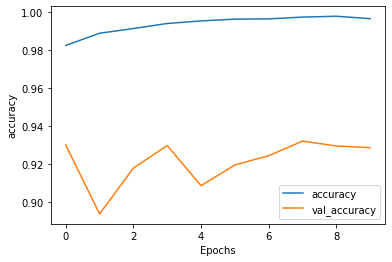

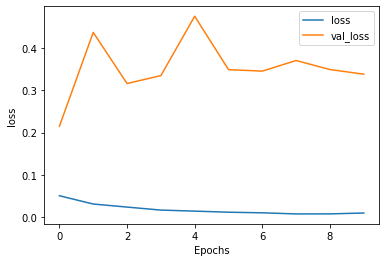

In [11]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')